<a href="https://colab.research.google.com/github/Nawel-Bellil/Les-files-d-attentes-MM1-GM1-MG1/blob/main/code/mg1_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from collections import deque
from scipy import stats
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import os

In [37]:


class QueueSimulator:
    """
    Classe abstraite de base pour simuler les systèmes de files d'attente.

    Cette classe fournit l'infrastructure de base pour simuler différents types
    de files d'attente mono-serveur en utilisant une approche d'événements discrets.
    """
    def __init__(self, lambda_rate, mu_rate, num_customers=1000000, seed=42):
        """
        Initialise le simulateur.

        Args:
            lambda_rate (float): Taux d'arrivée moyen (λ)
            mu_rate (float): Taux de service moyen (μ)
            num_customers (int): Nombre de clients à simuler
            seed (int): Graine pour la génération de nombres aléatoires
        """
        if lambda_rate <= 0 or mu_rate <= 0:
            raise ValueError("Les taux d'arrivée et de service doivent être positifs")
        if lambda_rate >= mu_rate:
            print(f"Attention: λ={lambda_rate} >= μ={mu_rate}, le système peut être instable")

        self.lambda_rate = lambda_rate
        self.mu_rate = mu_rate
        self.num_customers = num_customers
        self.rng = np.random.RandomState(seed)

        # Métriques à collecter
        self.waiting_times = np.zeros(num_customers)
        self.response_times = np.zeros(num_customers)
        self.server_busy_time = 0
        self.last_event_time = 0
        self.total_simulation_time = 0

        # Variables de simulation
        self.queue = deque()
        self.server_busy = False

    def generate_interarrival_time(self):
        """
        Génère le temps entre deux arrivées consécutives.
        À implémenter dans les classes dérivées.
        """
        raise NotImplementedError("Les classes dérivées doivent implémenter cette méthode")

    def generate_service_time(self):
        """
        Génère le temps de service d'un client.
        À implémenter dans les classes dérivées.
        """
        raise NotImplementedError("Les classes dérivées doivent implémenter cette méthode")

    def run_simulation(self):
        """
        Exécute la simulation d'événements discrets.

        Cette méthode implémente l'algorithme principal de simulation pour
        un système de file d'attente mono-serveur.
        """
        print(f"Démarrage de la simulation avec {self.num_customers} clients...")

        # Initialiser les temps d'arrivée et de départ
        arrival_times = np.zeros(self.num_customers)
        departure_times = np.zeros(self.num_customers)

        # Générer les temps d'inter-arrivée
        inter_arrival_times = np.array([self.generate_interarrival_time()
                                      for _ in range(self.num_customers)])

        # Calculer les temps d'arrivée absolus
        arrival_times[0] = inter_arrival_times[0]
        for i in range(1, self.num_customers):
            arrival_times[i] = arrival_times[i-1] + inter_arrival_times[i]

        # Initialiser la simulation
        departure_time = 0

        # Parcourir tous les clients avec barre de progression
        for i in tqdm(range(self.num_customers), desc="Simulation en cours"):
            arrival_time = arrival_times[i]
            service_time = self.generate_service_time()

            # Si le serveur est libre à l'arrivée du client
            if arrival_time >= departure_time:
                waiting_time = 0
                # Le départ est programmé après le temps de service
                departure_time = arrival_time + service_time
                self.server_busy_time += service_time
            else:
                # Le client doit attendre
                waiting_time = departure_time - arrival_time
                self.server_busy_time += service_time
                # Mettre à jour le temps de départ
                departure_time += service_time

            # Enregistrer les métriques
            self.waiting_times[i] = waiting_time
            self.response_times[i] = waiting_time + service_time
            departure_times[i] = departure_time

        # Durée totale de la simulation
        self.total_simulation_time = departure_times[-1]

        # Calculer les métriques finales
        self.calculate_metrics()

    def calculate_metrics(self):
        """
        Calcule les métriques finales de la simulation.
        """
        self.avg_waiting_time = np.mean(self.waiting_times)
        self.avg_response_time = np.mean(self.response_times)
        self.utilization = self.server_busy_time / self.total_simulation_time
        self.theoretical_utilization = self.lambda_rate / self.mu_rate

        # Calcul des métriques additionnelles
        self.max_waiting_time = np.max(self.waiting_times)
        self.max_response_time = np.max(self.response_times)
        self.std_waiting_time = np.std(self.waiting_times)
        self.std_response_time = np.std(self.response_times)

        # Percentiles
        self.waiting_time_95th = np.percentile(self.waiting_times, 95)
        self.response_time_95th = np.percentile(self.response_times, 95)

        if hasattr(self, 'get_theoretical_metrics'):
            self.theoretical_metrics = self.get_theoretical_metrics()

    def get_results(self):
        """
        Renvoie les résultats de la simulation sous forme de dictionnaire.
        """
        return {
            'lambda': self.lambda_rate,
            'mu': self.mu_rate,
            'rho': self.utilization,
            'theoretical_rho': self.theoretical_utilization,
            'avg_waiting_time': self.avg_waiting_time,
            'avg_response_time': self.avg_response_time,
            'max_waiting_time': self.max_waiting_time,
            'max_response_time': self.max_response_time,
            'std_waiting_time': self.std_waiting_time,
            'std_response_time': self.std_response_time,
            'waiting_time_95th': self.waiting_time_95th,
            'response_time_95th': self.response_time_95th,
            'num_customers': self.num_customers,
            'simulation_time': self.total_simulation_time
        }

    def print_summary(self):
        """
        Affiche un résumé des résultats de simulation.
        """
        print(f"\n{'='*50}")
        print(f"RÉSULTATS DE SIMULATION - {self.__class__.__name__}")
        print(f"{'='*50}")
        print(f"Paramètres:")
        print(f"  λ (taux d'arrivée): {self.lambda_rate}")
        print(f"  μ (taux de service): {self.mu_rate}")
        print(f"  Nombre de clients: {self.num_customers}")
        print(f"\nMétriques principales:")
        print(f"  Taux d'occupation (ρ): {self.utilization:.4f}")
        print(f"  Temps d'attente moyen: {self.avg_waiting_time:.4f}")
        print(f"  Temps de réponse moyen: {self.avg_response_time:.4f}")
        print(f"\nMétriques de variabilité:")
        print(f"  Écart-type temps d'attente: {self.std_waiting_time:.4f}")
        print(f"  Écart-type temps de réponse: {self.std_response_time:.4f}")
        print(f"  95e percentile temps d'attente: {self.waiting_time_95th:.4f}")
        print(f"  95e percentile temps de réponse: {self.response_time_95th:.4f}")


In [38]:


class MG1Simulator(QueueSimulator):
    """
    Simulateur pour le système M/G/1 où:
    - Les arrivées suivent une loi exponentielle (M)
    - Les temps de service suivent une loi générale (G)
    - Il y a un seul serveur (1)

    Pour ce simulateur, nous utiliserons une distribution gamma
    comme exemple de loi générale pour les services.
    """
    def __init__(self, lambda_rate, mu_rate, shape=2.0, num_customers=1000000, seed=42):
        super().__init__(lambda_rate, mu_rate, num_customers, seed)
        self.shape = shape  # Paramètre de forme pour la distribution gamma

        # Ajuster l'échelle pour que la moyenne soit 1/mu_rate
        # Pour Gamma: moyenne = shape * scale
        self.scale = 1.0 / (mu_rate * shape)

    def generate_interarrival_time(self):
        """
        Génère un temps inter-arrivée selon une distribution exponentielle.

        Returns:
            float: Temps jusqu'à la prochaine arrivée
        """
        return self.rng.exponential(scale=1/self.lambda_rate)

    def generate_service_time(self):
        """
        Génère un temps de service selon une distribution gamma.

        Returns:
            float: Temps de service pour le client
        """
        return self.rng.gamma(shape=self.shape, scale=self.scale)

    def get_theoretical_metrics(self):
        """
        Calcule les métriques théoriques pour le système M/G/1
        en utilisant la formule de Pollaczek-Khinchine.

        Returns:
            dict: Métriques théoriques
        """
        rho = self.lambda_rate / self.mu_rate

        # Vérifier que le système est stable
        if rho >= 1:
            return {
                'rho': rho,
                'avg_waiting_time': float('inf'),
                'avg_response_time': float('inf'),
                'avg_queue_length': float('inf')
            }

        # Variance du temps de service (pour la distribution gamma)
        var_service = self.shape * self.scale**2

        # Formule de Pollaczek-Khinchine
        avg_waiting_time = (self.lambda_rate * ((1/self.mu_rate)**2 + var_service)) / (2 * (1 - rho))
        avg_response_time = avg_waiting_time + 1/self.mu_rate
        avg_queue_length = self.lambda_rate * avg_waiting_time

        return {
            'rho': rho,
            'avg_waiting_time': avg_waiting_time,
            'avg_response_time': avg_response_time,
            'avg_queue_length': avg_queue_length
        }


In [39]:
def run_mg1_experiment(lambda_values, mu=1.0, shape=2.0, num_customers=1000000, num_runs=5, save_csv=True, output_dir="results"):
    """
    Exécute une série d'expériences M/G/1 avec différentes valeurs de λ et exporte les résultats vers un fichier CSV.

    Args:
        lambda_values: Liste des valeurs λ à tester
        mu: Taux de service μ
        shape: Paramètre de forme pour la distribution gamma
        num_customers: Nombre de clients à simuler pour chaque expérience
        num_runs: Nombre d'exécutions pour chaque expérience
        save_csv: Booléen pour décider de sauvegarder les résultats en CSV
        output_dir: Dossier de sortie pour les fichiers CSV

    Returns:
        DataFrame contenant les résultats moyennés
    """
    results = []

    print(f"\nExécution d'expériences M/G/1")
    print(f"Lambda de {min(lambda_values)} à {max(lambda_values)}, μ = {mu}, shape = {shape}")

    for lambda_val in tqdm(lambda_values, desc="Simulation M/G/1"):
        if lambda_val >= mu:
            print(f"⚠️ Attention: λ={lambda_val} >= μ={mu}, les résultats peuvent être instables")

        run_results = []

        for run in range(num_runs):
            simulator = MG1Simulator(
                lambda_val, mu,
                shape=shape,
                num_customers=num_customers,
                seed=42+run
            )
            simulator.run_simulation()
            run_results.append(simulator.get_results())

        avg_result = {
            'lambda': lambda_val,
            'mu': mu,
            'shape': shape,
            'rho': np.mean([r['rho'] for r in run_results]),
            'theoretical_rho': lambda_val / mu,
            'avg_waiting_time': np.mean([r['avg_waiting_time'] for r in run_results]),
            'avg_response_time': np.mean([r['avg_response_time'] for r in run_results]),
            'std_waiting_time': np.std([r['avg_waiting_time'] for r in run_results]),
            'std_response_time': np.std([r['avg_response_time'] for r in run_results]),
            'max_waiting_time': np.mean([r['max_waiting_time'] for r in run_results]),
            'max_response_time': np.mean([r['max_response_time'] for r in run_results]),
            'waiting_time_95th': np.mean([r['waiting_time_95th'] for r in run_results]),
            'response_time_95th': np.mean([r['response_time_95th'] for r in run_results])
        }

        results.append(avg_result)

    df_results = pd.DataFrame(results)

    if save_csv:
        os.makedirs(output_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"MG1_lambda{min(lambda_values)}-{max(lambda_values)}_mu{mu}_shape{shape}_{timestamp}.csv"
        filepath = os.path.join(output_dir, filename)
        df_results.to_csv(filepath, index=False)
        print(f"\n✅ Résultats sauvegardés dans : {filepath}")

    return df_results


In [40]:
def plot_mg1_metrics(results, title_suffix=""):
    """
    Trace les métriques M/G/1 en fonction du taux d'occupation.

    Args:
        results: DataFrame des résultats M/G/1
        title_suffix: Suffixe à ajouter aux titres

    Returns:
        Figure matplotlib créée
    """
    fig, ax = plt.subplots(2, 2, figsize=(15, 12))

    # Temps de réponse vs ρ
    ax[0,0].plot(results['rho'], results['avg_response_time'], 'o-',
                 linewidth=2, markersize=8, color='blue')
    ax[0,0].set_xlabel('Taux d\'occupation (ρ)')
    ax[0,0].set_ylabel('Temps de réponse moyen')
    ax[0,0].set_title(f'Temps de réponse moyen vs ρ - M/G/1{title_suffix}')
    ax[0,0].grid(True, alpha=0.3)

    # Temps d'attente vs ρ
    ax[0,1].plot(results['rho'], results['avg_waiting_time'], 'o-',
                 linewidth=2, markersize=8, color='red')
    ax[0,1].set_xlabel('Taux d\'occupation (ρ)')
    ax[0,1].set_ylabel('Temps d\'attente moyen')
    ax[0,1].set_title(f'Temps d\'attente moyen vs ρ - M/G/1{title_suffix}')
    ax[0,1].grid(True, alpha=0.3)

    # Temps de réponse vs λ
    ax[1,0].plot(results['lambda'], results['avg_response_time'], 's-',
                 linewidth=2, markersize=8, color='green')
    ax[1,0].set_xlabel('Taux d\'arrivée (λ)')
    ax[1,0].set_ylabel('Temps de réponse moyen')
    ax[1,0].set_title(f'Temps de réponse moyen vs λ - M/G/1{title_suffix}')
    ax[1,0].grid(True, alpha=0.3)

    # 95e percentile temps d'attente vs ρ
    ax[1,1].plot(results['rho'], results['waiting_time_95th'], '^-',
                 linewidth=2, markersize=8, color='purple')
    ax[1,1].set_xlabel('Taux d\'occupation (ρ)')
    ax[1,1].set_ylabel('95e percentile temps d\'attente')
    ax[1,1].set_title(f'95e percentile temps d\'attente vs ρ - M/G/1{title_suffix}')
    ax[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig



In [41]:
def compare_mg1_shapes(lambda_values, mu, shapes, num_customers, num_runs, output_dir="results"):
    """
    Compare plusieurs formes de distributions pour un système M/G/1.

    Args:
        lambda_values: Liste de valeurs λ
        mu: Taux de service
        shapes: Liste de formes à tester
        num_customers: Nombre de clients par exécution
        num_runs: Nombre d'exécutions
        output_dir: Dossier où sauvegarder les CSV

    Returns:
        Dictionnaire des DataFrames de résultats par forme.
    """
    results_by_shape = {}

    for shape in shapes:
        print(f"\n🔍 Simulation M/G/1 avec shape = {shape}")
        df = run_mg1_experiment(
            lambda_values, mu=mu, shape=shape,
            num_customers=num_customers, num_runs=num_runs,
            save_csv=True, output_dir=output_dir
        )
        results_by_shape[shape] = df

    return results_by_shape


In [42]:


def plot_shape_comparison(results_by_shape, metric='avg_response_time'):
    """
    Trace une comparaison des résultats M/G/1 pour différentes formes.

    Args:
        results_by_shape: Dict contenant les résultats pour chaque forme
        metric: Métrique à comparer

    Returns:
        Figure matplotlib créée
    """
    plt.figure(figsize=(12, 8))

    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
    markers = ['o', 's', '^', 'D', 'v', 'p']

    for i, (shape, results) in enumerate(results_by_shape.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]

        plt.plot(results['lambda'], results[metric],
                marker=marker, linestyle='-', linewidth=2, markersize=8,
                label=f'Shape = {shape}', color=color)

    plt.xlabel('Taux d\'arrivée (λ)')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Comparaison M/G/1: {metric.replace("_", " ").title()} vs λ pour différentes formes')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    return plt.gcf()


In [43]:
def main():
    """
    Fonction principale pour exécuter les simulations M/G/1.
    """
    print("🚀 Démarrage de la simulation M/G/1...")
    print(f"{'='*50}")


    start_time = time.time()

    # Répertoires de sortie
    output_dir = "results"
    graphs_dir = "graphs"

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(graphs_dir, exist_ok=True)

    # Paramètres de simulation
    lambda_values = np.arange(0.1, 0.95, 0.1)  # Taux d'arrivée
    mu = 1.0  # Taux de service fixe
    num_customers = 100000  # Nombre de clients par simulation
    num_runs = 3  # Nombre d'exécutions par configuration

    print(f"Démarrage des simulations M/G/1 avec {num_customers} clients par exécution...")

    # Test simple avec un seul simulateur
    print("\nTest M/G/1 avec shape=2.0:")
    mg1 = MG1Simulator(0.8, 1.0, shape=2.0, num_customers=50000, seed=42)
    mg1.run_simulation()
    mg1.print_summary()

    # Comparaison avec les valeurs théoriques
    theoretical_mg1 = mg1.get_theoretical_metrics()
    print(f"\nComparaison théorique vs simulation (M/G/1):")
    print(f"Temps d'attente - Théorique: {theoretical_mg1['avg_waiting_time']:.4f}, Simulé: {mg1.avg_waiting_time:.4f}")
    print(f"Temps de réponse - Théorique: {theoretical_mg1['avg_response_time']:.4f}, Simulé: {mg1.avg_response_time:.4f}")

    # Expériences avec différentes formes
    shapes_to_test = [0.5, 1.0, 2.0, 4.0]
    print(f"\nComparaison de différentes formes: {shapes_to_test}")

    results_by_shape = compare_mg1_shapes(
        lambda_values, mu, shapes_to_test, num_customers, num_runs, output_dir
    )

    # Affichage des résultats
    for shape, results in results_by_shape.items():
        print(f"\nRésultats M/G/1 (shape={shape}):")
        print(results[['lambda', 'rho', 'avg_waiting_time', 'avg_response_time']].head())

    # Création des graphiques
    print("\nCréation des graphiques...")

    # Graphique pour shape=2.0
    if 2.0 in results_by_shape:
        fig1 = plot_mg1_metrics(results_by_shape[2.0], " (shape=2.0)")
        fig1_path = os.path.join(graphs_dir, 'mg1_metrics_shape2.png')
        plt.savefig(fig1_path, dpi=300, bbox_inches='tight')
        print(f"Graphique sauvegardé: {fig1_path}")

    # Comparaison des différentes formes - temps de réponse
    fig2 = plot_shape_comparison(results_by_shape, 'avg_response_time')
    fig2_path = os.path.join(graphs_dir, 'mg1_shape_comparison_response_time.png')
    plt.savefig(fig2_path, dpi=300, bbox_inches='tight')
    print(f"Graphique sauvegardé: {fig2_path}")

    # Comparaison des différentes formes - temps d'attente
    fig3 = plot_shape_comparison(results_by_shape, 'avg_waiting_time')
    fig3_path = os.path.join(graphs_dir, 'mg1_shape_comparison_waiting_time.png')
    plt.savefig(fig3_path, dpi=300, bbox_inches='tight')
    print(f"Graphique sauvegardé: {fig3_path}")

    end_time = time.time()
    print(f"\nTemps total d'exécution: {end_time - start_time:.2f} secondes")
    print("Simulation M/G/1 terminée avec succès!")


🚀 Démarrage de la simulation M/G/1...
Démarrage des simulations M/G/1 avec 100000 clients par exécution...

Test M/G/1 avec shape=2.0:
Démarrage de la simulation avec 50000 clients...


Simulation en cours: 100%|██████████| 50000/50000 [00:00<00:00, 257867.59it/s]



RÉSULTATS DE SIMULATION - MG1Simulator
Paramètres:
  λ (taux d'arrivée): 0.8
  μ (taux de service): 1.0
  Nombre de clients: 50000

Métriques principales:
  Taux d'occupation (ρ): 0.8060
  Temps d'attente moyen: 3.0173
  Temps de réponse moyen: 4.0209

Métriques de variabilité:
  Écart-type temps d'attente: 3.4992
  Écart-type temps de réponse: 3.5664
  95e percentile temps d'attente: 9.9459
  95e percentile temps de réponse: 11.0400

Comparaison théorique vs simulation (M/G/1):
Temps d'attente - Théorique: 3.0000, Simulé: 3.0173
Temps de réponse - Théorique: 4.0000, Simulé: 4.0209

Comparaison de différentes formes: [0.5, 1.0, 2.0, 4.0]

🔍 Simulation M/G/1 avec shape = 0.5

Exécution d'expériences M/G/1
Lambda de 0.1 à 0.9, μ = 1.0, shape = 0.5


Simulation M/G/1:   0%|          | 0/9 [00:00<?, ?it/s]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 257824.95it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 249674.77it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  11%|█         | 1/9 [00:01<00:14,  1.75s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 439661.42it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 443526.77it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  22%|██▏       | 2/9 [00:02<00:09,  1.39s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 419044.46it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 411718.50it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  33%|███▎      | 3/9 [00:04<00:07,  1.28s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 431028.52it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 414015.08it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  44%|████▍     | 4/9 [00:05<00:06,  1.22s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 437600.45it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 441961.14it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  56%|█████▌    | 5/9 [00:06<00:04,  1.20s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 405725.79it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 429927.95it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  67%|██████▋   | 6/9 [00:07<00:03,  1.18s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 399155.31it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 417721.50it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  78%|███████▊  | 7/9 [00:08<00:02,  1.18s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 415319.98it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 433977.32it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  89%|████████▉ | 8/9 [00:09<00:01,  1.19s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 415441.74it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 419462.70it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]



✅ Résultats sauvegardés dans : results/MG1_lambda0.1-0.9_mu1.0_shape0.5_20250523_121746.csv

🔍 Simulation M/G/1 avec shape = 1.0

Exécution d'expériences M/G/1
Lambda de 0.1 à 0.9, μ = 1.0, shape = 1.0


Simulation M/G/1:   0%|          | 0/9 [00:00<?, ?it/s]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 447075.30it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 254971.49it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  11%|█         | 1/9 [00:01<00:13,  1.67s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 270583.67it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 244330.76it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  22%|██▏       | 2/9 [00:03<00:12,  1.74s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 450175.11it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 416006.25it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  33%|███▎      | 3/9 [00:04<00:08,  1.46s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 453899.53it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 446344.05it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  44%|████▍     | 4/9 [00:05<00:06,  1.33s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 454080.36it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 395958.38it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  56%|█████▌    | 5/9 [00:06<00:05,  1.27s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 414718.78it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 446811.45it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  67%|██████▋   | 6/9 [00:08<00:03,  1.22s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 406110.78it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 433762.34it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  78%|███████▊  | 7/9 [00:09<00:02,  1.19s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 435834.79it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 450152.40it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  89%|████████▉ | 8/9 [00:10<00:01,  1.18s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 436954.00it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 446715.80it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1: 100%|██████████| 9/9 [00:11<00:00,  1.27s/it]



✅ Résultats sauvegardés dans : results/MG1_lambda0.1-0.9_mu1.0_shape1.0_20250523_121757.csv

🔍 Simulation M/G/1 avec shape = 2.0

Exécution d'expériences M/G/1
Lambda de 0.1 à 0.9, μ = 1.0, shape = 2.0


Simulation M/G/1:   0%|          | 0/9 [00:00<?, ?it/s]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 447617.31it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 450012.82it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  11%|█         | 1/9 [00:01<00:08,  1.12s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 451079.98it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 354356.69it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  22%|██▏       | 2/9 [00:02<00:09,  1.33s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 253560.35it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 264248.91it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  33%|███▎      | 3/9 [00:04<00:09,  1.63s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 432478.72it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 421205.78it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  44%|████▍     | 4/9 [00:05<00:07,  1.46s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 437848.04it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 443114.89it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  56%|█████▌    | 5/9 [00:06<00:05,  1.34s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 389937.84it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 438819.65it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  67%|██████▋   | 6/9 [00:08<00:03,  1.28s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 406264.98it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 427655.93it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  78%|███████▊  | 7/9 [00:09<00:02,  1.24s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 429197.65it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 422945.50it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  89%|████████▉ | 8/9 [00:10<00:01,  1.22s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 419611.67it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 437083.32it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1: 100%|██████████| 9/9 [00:11<00:00,  1.28s/it]



✅ Résultats sauvegardés dans : results/MG1_lambda0.1-0.9_mu1.0_shape2.0_20250523_121809.csv

🔍 Simulation M/G/1 avec shape = 4.0

Exécution d'expériences M/G/1
Lambda de 0.1 à 0.9, μ = 1.0, shape = 4.0


Simulation M/G/1:   0%|          | 0/9 [00:00<?, ?it/s]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 424663.53it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 449450.55it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  11%|█         | 1/9 [00:01<00:09,  1.14s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 435950.75it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 424126.33it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  22%|██▏       | 2/9 [00:02<00:08,  1.15s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 448148.18it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 416679.48it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  33%|███▎      | 3/9 [00:03<00:07,  1.26s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 241266.46it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 262800.67it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  44%|████▍     | 4/9 [00:05<00:07,  1.56s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 371770.53it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 427748.40it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  56%|█████▌    | 5/9 [00:07<00:05,  1.47s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 421950.29it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 433006.00it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  67%|██████▋   | 6/9 [00:08<00:04,  1.37s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 431674.86it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 429899.31it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  78%|███████▊  | 7/9 [00:09<00:02,  1.30s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 430400.00it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 424659.66it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1:  89%|████████▉ | 8/9 [00:10<00:01,  1.26s/it]

Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 425122.36it/s]


Démarrage de la simulation avec 100000 clients...



Simulation en cours: 100%|██████████| 100000/100000 [00:00<00:00, 426191.07it/s]


Démarrage de la simulation avec 100000 clients...



Simulation M/G/1: 100%|██████████| 9/9 [00:11<00:00,  1.30s/it]



✅ Résultats sauvegardés dans : results/MG1_lambda0.1-0.9_mu1.0_shape4.0_20250523_121820.csv

Résultats M/G/1 (shape=0.5):
   lambda       rho  avg_waiting_time  avg_response_time
0     0.1  0.100034          0.169098           1.169452
1     0.2  0.200066          0.380093           1.380448
2     0.3  0.300098          0.649067           1.649422
3     0.4  0.400129          1.005322           2.005677
4     0.5  0.500158          1.499844           2.500199

Résultats M/G/1 (shape=1.0):
   lambda       rho  avg_waiting_time  avg_response_time
0     0.1  0.099849          0.111300           1.109801
1     0.2  0.199697          0.249137           1.247637
2     0.3  0.299545          0.426345           1.424846
3     0.4  0.399393          0.663466           1.661966
4     0.5  0.499240          0.996913           1.995413

Résultats M/G/1 (shape=2.0):
   lambda       rho  avg_waiting_time  avg_response_time
0     0.1  0.100047          0.082524           1.083009
1     0.2  0.200093

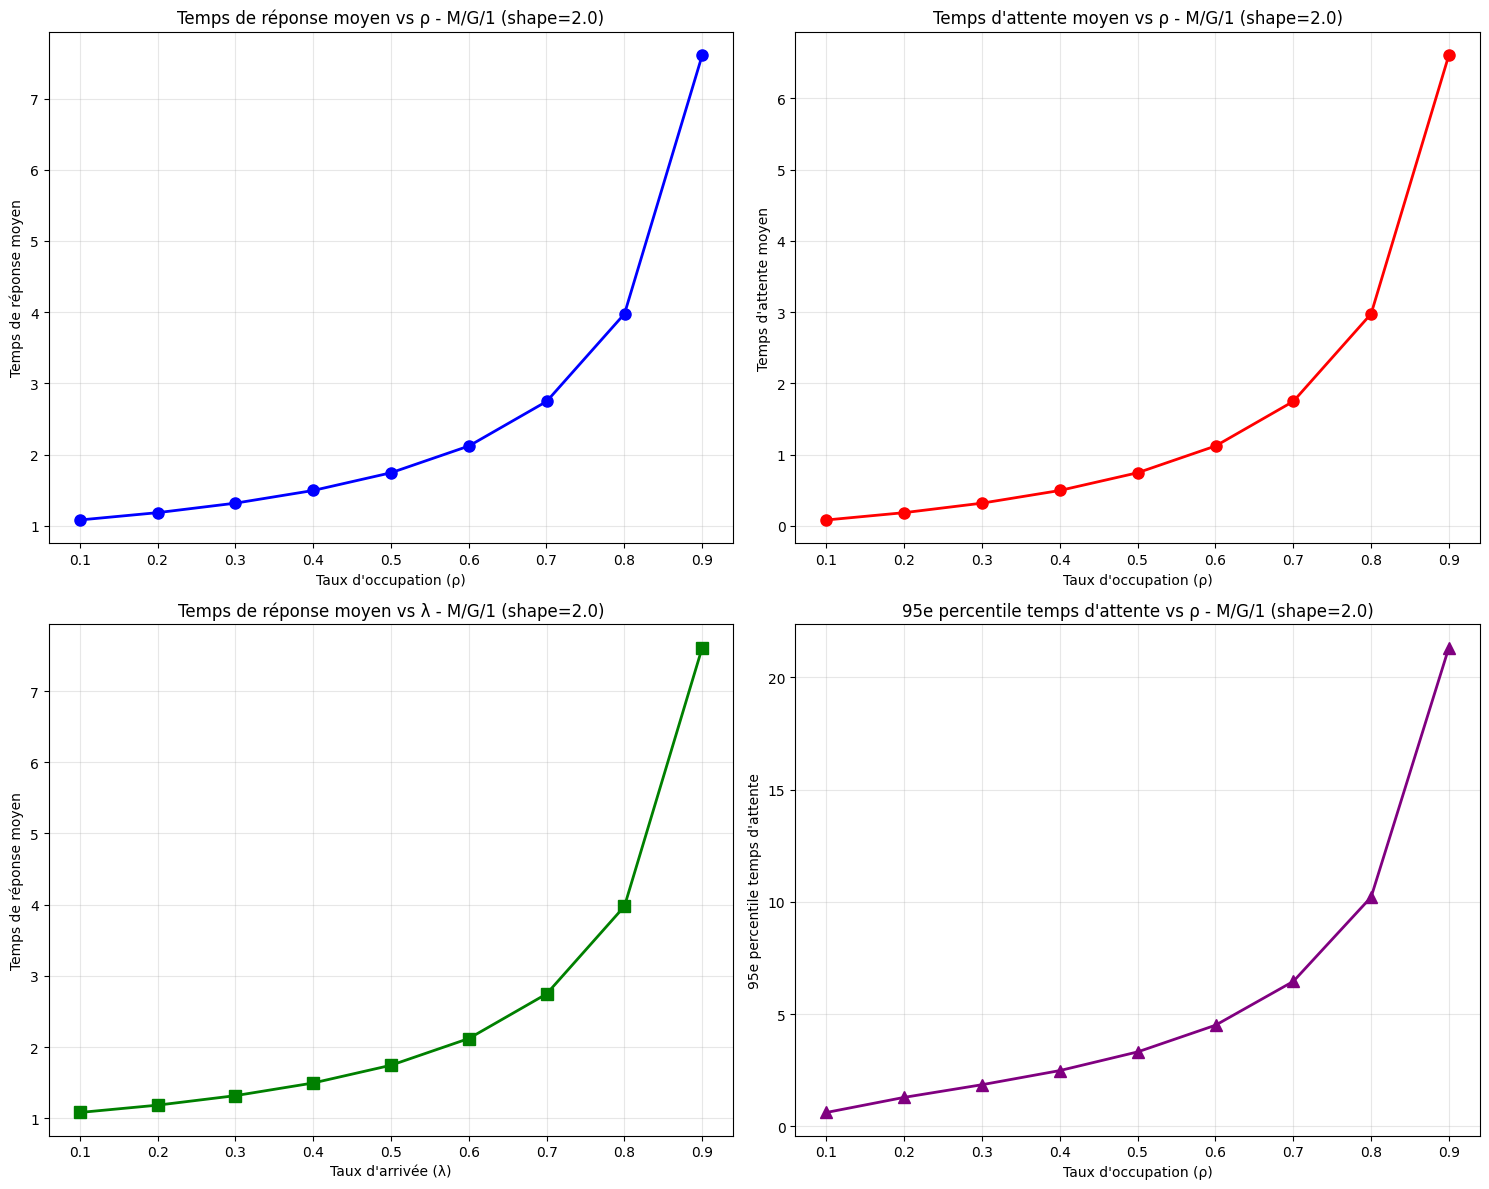

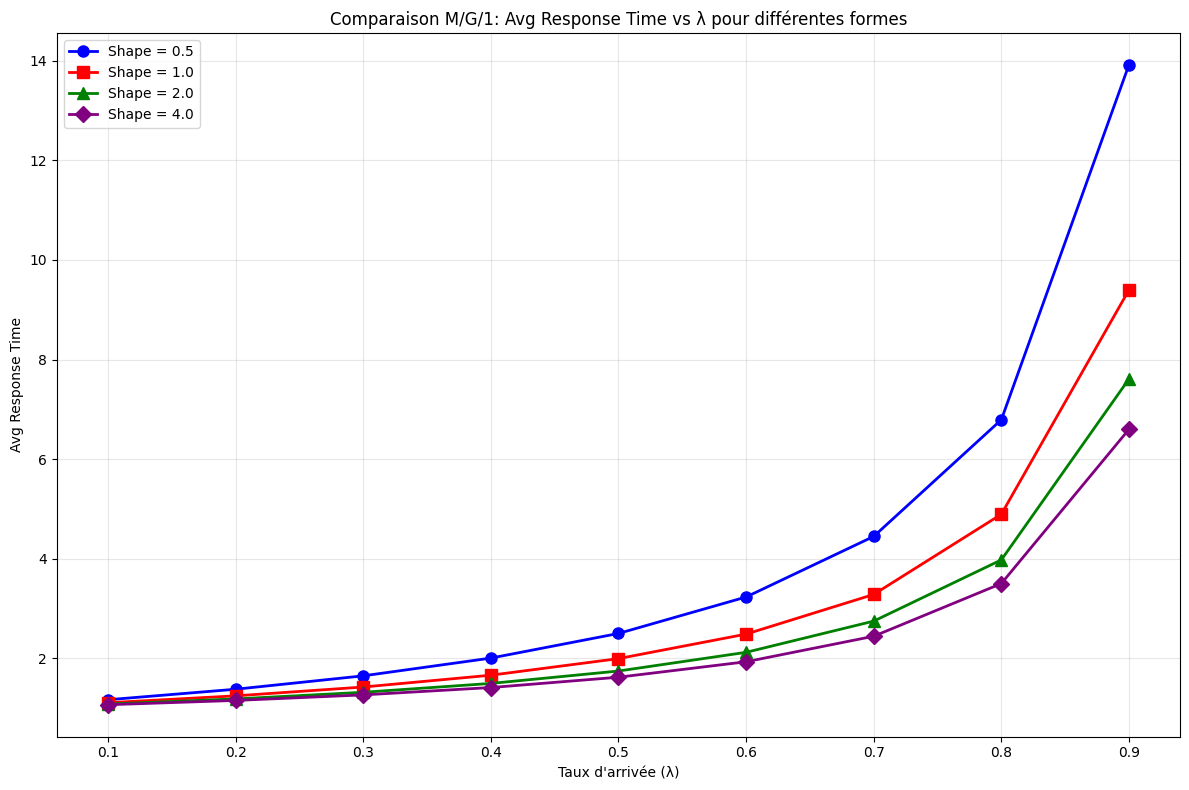

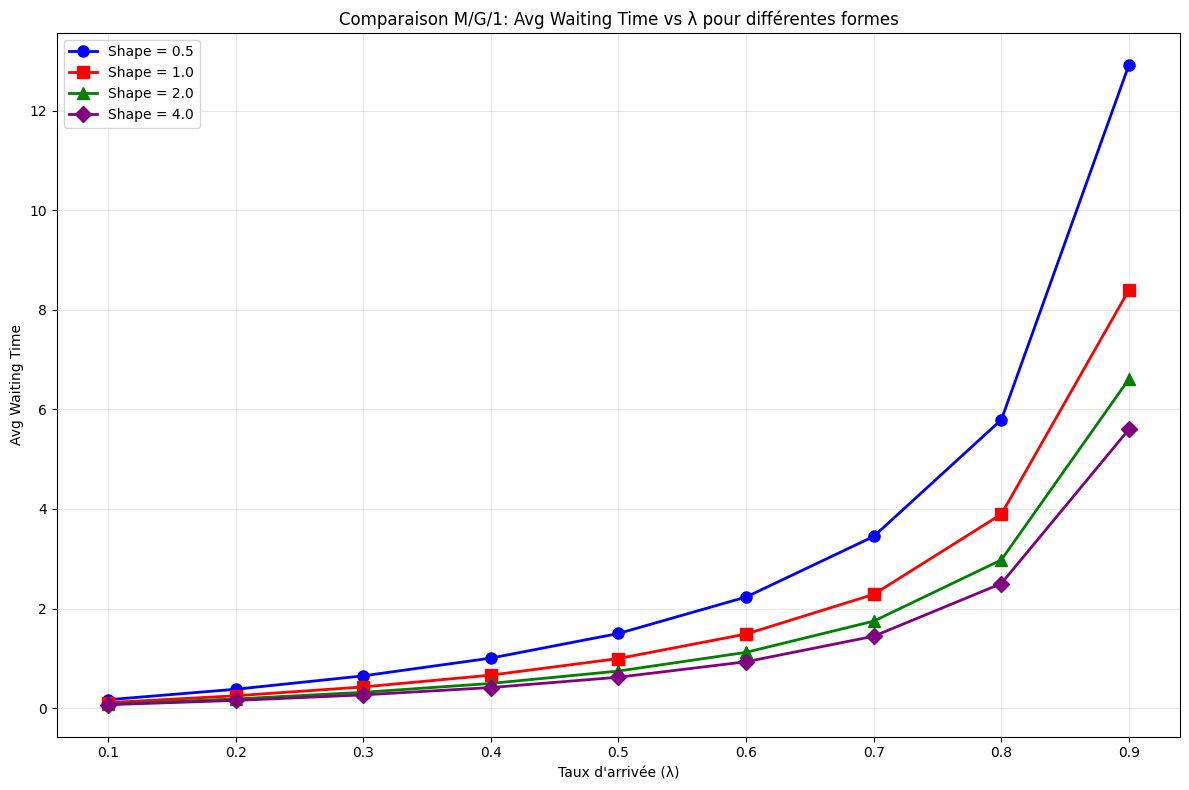

In [44]:

if __name__ == "__main__":
    main()



print(f"\n✅ Tous les fichiers CSV sont disponibles dans le dossier : {output_dir}")
